# Johnson Rauschen
Erstmal bisschen Sachen laden

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import xlsxwriter
import pandas as pd

## Johnson Rauschen Widerstand
### Daten einlesen und $V_J^2$ berechnen

In [2]:
data1 = np.loadtxt('../data/johnson_widerstand.txt', skiprows=1)
R = data1[:,0] # in Ohm
R_err = 0.01 * R    # 1% Messunsicherheit
G = data1[:,1]  # Gain
U_DMM = data1[:,2]  # in Volt
U_DMM_err = np.full_like(U_DMM, 0.005)  # 5mV Messunsicherheit

T = 21.4 +273.15    # Raumtemperatur in Kelvin
T_err = 0.1            # Temperaturschwankung über die Zeit in Kelvin
k_B = 1.380649e-23  # Boltzmann-Konstante in J/K
delta_f = 11396.69   # in Hz
delta_f_err = 463.40  # 5% Unsicherheit
const = 4 * k_B * T * delta_f  # 
const_err = np.sqrt( (4*k_B* T_err * delta_f)**2 + (4*k_B * T * delta_f_err)**2 )
def U_J_squared(U, G):
    return (U * 10) / (600 * G)**2  # in Volt_squared

def U_J_squared_err(U, U_err, G):
    return np.sqrt(((10*U_err)/(600*G)**2)**2)

U_J2 = U_J_squared(U_DMM, G)
U_J2_err = U_J_squared_err(U_DMM, U_DMM_err, G)

for Ri, R_erri, Gi, U_DMMi, U_DMM_erri, U_J2i, U_J2_erri in zip(R, R_err, G, U_DMM, U_DMM_err, U_J2, U_J2_err):
    print(f"R: {Ri:.2f} ± {R_erri:.2f} Ohm, G: {Gi:.2f}, U_DMM: {U_DMMi:.3f} ± {U_DMM_erri:.3f} V, U_J^2: {U_J2i*10**12:.6f} ± {U_J2_erri*10**12:.6f} V²")


R: 1.00 ± 0.01 Ohm, G: 2000.00, U_DMM: 1.003 ± 0.005 V, U_J^2: 6.963889 ± 0.034722 V²
R: 10.00 ± 0.10 Ohm, G: 2000.00, U_DMM: 1.004 ± 0.005 V, U_J^2: 6.973611 ± 0.034722 V²
R: 100.00 ± 1.00 Ohm, G: 2000.00, U_DMM: 1.026 ± 0.005 V, U_J^2: 7.122917 ± 0.034722 V²
R: 1000.00 ± 10.00 Ohm, G: 1500.00, U_DMM: 0.714 ± 0.005 V, U_J^2: 8.813580 ± 0.061728 V²
R: 10000.00 ± 100.00 Ohm, G: 1000.00, U_DMM: 0.924 ± 0.005 V, U_J^2: 25.675000 ± 0.138889 V²
R: 100000.00 ± 1000.00 Ohm, G: 400.00, U_DMM: 0.840 ± 0.005 V, U_J^2: 145.781250 ± 0.868056 V²
R: 1000000.00 ± 10000.00 Ohm, G: 300.00, U_DMM: 0.880 ± 0.005 V, U_J^2: 271.481481 ± 1.543210 V²


### Johnson Rauschen Widerstand fitten

=== Fit mit ersten Messwerten ===
Fit-Ergebnisse: m = 3.168e-16 ± 1.511e-18, b = 7.477e-12 ± 1.890e-14
Chi^2: 28796.46, dof: 5, reduced Chi^2: 5759.29
Bestimmte Boltzmann-Konstante: k_B = 2.359e-23 ± 9.660e-25 J/K
=== Fit ohne die letzten 2 Messwerte ===
Fit-Ergebnisse: m = 1.872e-15 ± 1.389e-17, b = 6.950e-12 ± 1.938e-14
Chi^2: 0.33, dof: 3, reduced Chi^2: 0.11
Bestimmte Boltzmann-Konstante: k_B = 1.394e-22 ± 5.762e-24 J/K
=== Fit ohne die letzten 1 Messwerte ===
Fit-Ergebnisse: m = 1.524e-15 ± 7.379e-18, b = 7.052e-12 ± 1.907e-14
Chi^2: 875.57, dof: 4, reduced Chi^2: 218.89
Bestimmte Boltzmann-Konstante: k_B = 1.135e-22 ± 4.647e-24 J/K


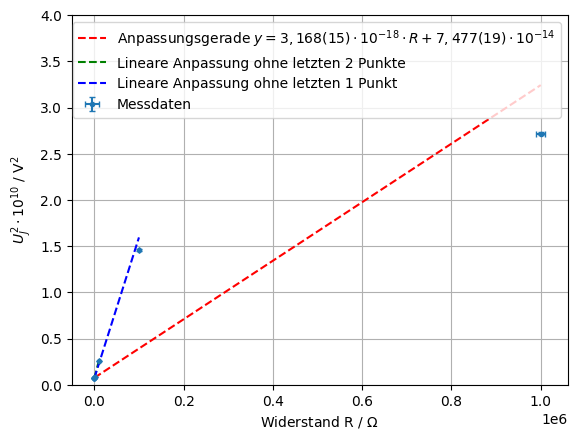

In [3]:

# linear fit an die Messwerte
x = R
x_err = R_err
y = U_J2
y_err = U_J2_err

x2 = R[:-2] #R_in in Ohm
y2 = U_J2[:-2] #Johnson noise in 10^-12 V^2
x2_err = 0.01*x2 #1%
y2_err = U_J2_err[:-2]

x3 = R[:-1] #R_in in Ohm
y3 = U_J2[:-1] #Johnson noise in 10^-12 V^2
x3_err = 0.01*x3 #1%
y3_err = U_J2_err[:-1]

def linear_func(x, m, b):
    return m * x + b

# === Fit mit dem ersten
print("=== Fit mit ersten Messwerten ===")
popt, pcov = curve_fit(linear_func, x, y, sigma=y_err, absolute_sigma=True)
m_fit, b_fit = popt
m_fit_err, b_fit_err = np.sqrt(np.diag(pcov))
print(f"Fit-Ergebnisse: m = {m_fit:.3e} ± {m_fit_err:.3e}, b = {b_fit:.3e} ± {b_fit_err:.3e}")

# -- compute chi^2
y_fit = linear_func(x, *popt)
chi2 = np.sum(((y - y_fit) / y_err) ** 2)
dof = len(y) - len(popt)
reduced_chi2 = chi2 / dof
print(f"Chi^2: {chi2:.2f}, dof: {dof}, reduced Chi^2: {reduced_chi2:.2f}")

# Berechne Boltzmann-Konstante aus dem Anstieg
k_B_fit = m_fit / (4* T * delta_f)
k_B_fit_err = np.sqrt(
    (m_fit_err / (4 * T * delta_f))**2 +
    ((m_fit * T_err) / (4*delta_f*T**2))**2 +
    ((m_fit * delta_f_err) / (4* T * delta_f**2))**2
)
print(f"Bestimmte Boltzmann-Konstante: k_B = {k_B_fit:.3e} ± {k_B_fit_err:.3e} J/K")

# === Fit ohne die letzten 2
print("=== Fit ohne die letzten 2 Messwerte ===")
popt2, pcov2 = curve_fit(linear_func, x2, y2, sigma=y2_err, absolute_sigma=True)
m_fit2, b_fit2 = popt2
m_fit2_err, b_fit2_err = np.sqrt(np.diag(pcov2))
print(f"Fit-Ergebnisse: m = {m_fit2:.3e} ± {m_fit2_err:.3e}, b = {b_fit2:.3e} ± {b_fit2_err:.3e}")
# -- compute chi^2
y2_fit = linear_func(x2, *popt2)
chi2_2 = np.sum(((y2 - y2_fit) / y2_err) ** 2)
dof2 = len(y2) - len(popt2)
reduced_chi2_2 = chi2_2 / dof2
print(f"Chi^2: {chi2_2:.2f}, dof: {dof2}, reduced Chi^2: {reduced_chi2_2:.2f}")
# Berechne Boltzmann-Konstante aus dem Anstieg
k_B_fit2 = m_fit2 / (4* T * delta_f)
k_B_fit2_err = np.sqrt(
    (m_fit2_err / (4 * T * delta_f))**2 +
    ((m_fit2 * T_err) / (4*delta_f*T**2))**2 +
    ((m_fit2 * delta_f_err) / (4* T * delta_f**2))**2
)
print(f"Bestimmte Boltzmann-Konstante: k_B = {k_B_fit2:.3e} ± {k_B_fit2_err:.3e} J/K")

# === Fit ohne die letzten 1
print("=== Fit ohne die letzten 1 Messwerte ===")
popt3, pcov3 = curve_fit(linear_func, x3, y3, sigma=y3_err, absolute_sigma=True)
m_fit3, b_fit3 = popt3
m_fit3_err, b_fit3_err = np.sqrt(np.diag(pcov3))
print(f"Fit-Ergebnisse: m = {m_fit3:.3e} ± {m_fit3_err:.3e}, b = {b_fit3:.3e} ± {b_fit3_err:.3e}")
# -- compute chi^2
y3_fit = linear_func(x3, *popt3)
chi2_3 = np.sum(((y3 - y3_fit) / y3_err) ** 2)
dof3 = len(y3) - len(popt3)
reduced_chi2_3 = chi2_3 / dof3
print(f"Chi^2: {chi2_3:.2f}, dof: {dof3}, reduced Chi^2: {reduced_chi2_3:.2f}")
# Berechne Boltzmann-Konstante aus dem Anstieg
k_B_fit3 = m_fit3 / (4* T * delta_f)
k_B_fit3_err = np.sqrt(
    (m_fit3_err / (4 * T * delta_f))**2 +
    ((m_fit3 * T_err) / (4*delta_f*T**2))**2 +
    ((m_fit3 * delta_f_err) / (4* T * delta_f**2))**2
)
print(f"Bestimmte Boltzmann-Konstante: k_B = {k_B_fit3:.3e} ± {k_B_fit3_err:.3e} J/K")

# plot the results
fig, ax = plt.subplots()
ax.errorbar(R, U_J2*10**10, xerr=R_err, yerr=U_J2_err*10**10, fmt='.', label='Messdaten', capsize=2)
ax.set_ylim(0, 4)
x_fit = np.linspace(min(R)*0.9, max(R)*1, 100)
y_fit = linear_func(x_fit, *popt)
x_fit2 = np.linspace(min(x2)*0.9, max(x2)*1, 100)
y2_fit = linear_func(x_fit2, *popt2)
x_fit3 = np.linspace(min(x3)*0.9, max(x3)*1, 100)
y3_fit = linear_func(x_fit3, *popt3)
ax.plot(x_fit, y_fit*10**10, 'r--', label=r'Anpassungsgerade $y = 3,168(15)\cdot 10^{-18} \cdot R + 7,477(19)\cdot 10^{-14}$')
ax.plot(x_fit2, y2_fit*10**10, 'g--', label='Lineare Anpassung ohne letzten 2 Punkte')
ax.plot(x_fit3, y3_fit*10**10, 'b--', label='Lineare Anpassung ohne letzten 1 Punkt')
#ax.set_xscale('log')
ax.set_xlabel(r'Widerstand R / $\Omega$')
ax.set_ylabel(r'$U_J^2 \cdot 10^{10}$ / $\mathrm{V}^2$')
plt.grid()
plt.legend()
plt.savefig('../plots/johnson_rauschen_widerstand.pdf', dpi=300)   
plt.show()


### Johnson Rauschen Widerstand Residuen

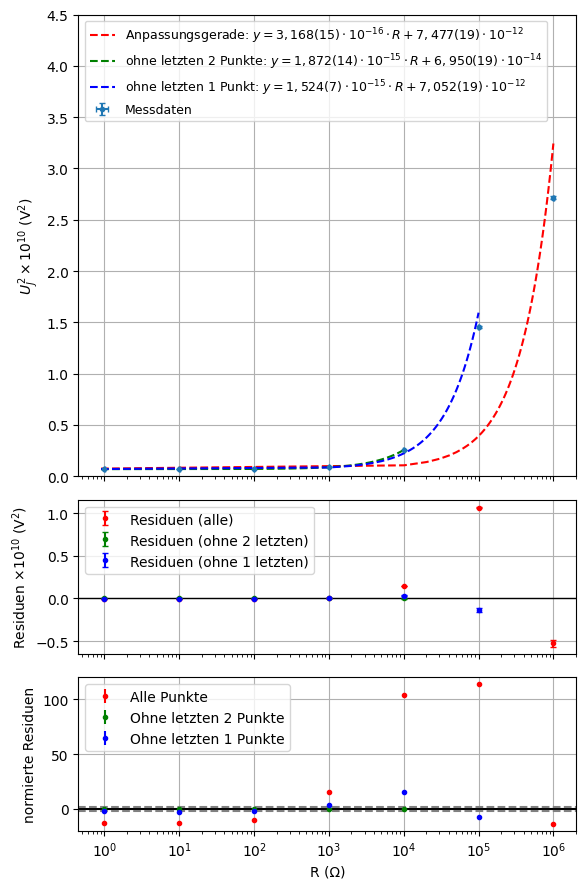

In [4]:
# === Residuals for both fits ===
residuals = y - linear_func(x, *popt)
residuals2 = y2 - linear_func(x2, *popt2)
residuals3 = y3 - linear_func(x3, *popt3)

# --- Unsicherheit der Modellvorhersage durch Parameterkovarianz ---
# 1) Fit mit allen Punkten
C  = pcov
m, b = popt
J  = np.vstack((x, np.ones_like(x))).T              # Jacobizeile [x_i, 1]
var_model = np.einsum('ij,jk,ik->i', J, C, J)       # J * C * J^T (diagonal)
# x-Fehlerterm (falls vorhanden, sonst 0)
var_x = (m * x_err)**2 if 'x_err' in locals() else 0.0

sigma_r = np.sqrt(y_err**2 + var_model + var_x)

# 2) Fit ohne letzten 2 Punkte
C2 = pcov2
m2, b2 = popt2
J2 = np.vstack((x2, np.ones_like(x2))).T
var_model2 = np.einsum('ij,jk,ik->i', J2, C2, J2)
var_x2 = (m2 * x2_err)**2 if 'x2_err' in locals() else 0.0

sigma_r2 = np.sqrt(y2_err**2 + var_model2 + var_x2)

# 2) Fit ohne letzten 1 Punkt
C3 = pcov3
m3, b3 = popt3
J3 = np.vstack((x3, np.ones_like(x3))).T
var_model3 = np.einsum('ij,jk,ik->i', J3, C3, J3)
var_x3 = (m3 * x3_err)**2 if 'x3_err' in locals() else 0.0

sigma_r3 = np.sqrt(y3_err**2 + var_model3 + var_x3)

# Optional: normalisierte (studentisierte) Residuen
norm_res  = residuals  / sigma_r
norm_res2 = residuals2 / sigma_r2
norm_res3 = residuals3 / sigma_r3


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True,
                               gridspec_kw={'height_ratios': [3, 1, 1]},
                               figsize=(6, 9))

# --- Upper plot: data + fits ---
ax1.set_ylim(0, 4.5)
ax1.set_xscale('log')
ax1.errorbar(R, U_J2*1e10, xerr=R_err, yerr=U_J2_err*1e10,
             fmt='.', capsize=2, label='Messdaten')
ax1.plot(x_fit, y_fit*1e10, 'r--', label=r'Anpassungsgerade: $y = 3,168(15)\cdot 10^{-16} \cdot R + 7,477(19)\cdot 10^{-12}$')
ax1.plot(x_fit2, y2_fit*1e10, 'g--', label=r'ohne letzten 2 Punkte: $y = 1,872(14)\cdot 10^{-15} \cdot R + 6,950(19)\cdot 10^{-14}$')
ax1.plot(x_fit3, y3_fit*1e10, 'b--', label=r'ohne letzten 1 Punkt: $y = 1,524(7)\cdot 10^{-15} \cdot R + 7,052(19)\cdot 10^{-12}$')
ax1.set_ylabel(r'$U_J^2 \times 10^{10}$ (V$^2$)')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True)

# --- Lower plot: residuals ---
# --- Residuenplot mit Fehlerbalken ---
ax2.axhline(0, color='k', lw=1)
ax2.set_xscale('log')
ax2.errorbar(x,  residuals*1e10,  yerr=sigma_r*1e10,  fmt='r.', capsize=2, label='Residuen (alle)')
ax2.errorbar(x2, residuals2*1e10, yerr=sigma_r2*1e10, fmt='g.', capsize=2, label='Residuen (ohne 2 letzten)')
ax2.errorbar(x3, residuals3*1e10, yerr=sigma_r3*1e10, fmt='b.', capsize=2, label='Residuen (ohne 1 letzten)')
ax3.set_xlabel('R (Ω)')
ax2.set_ylabel(r'Residuen $\times 10^{10}$ (V$^2$)')
ax2.grid(True); ax2.legend()

ax3.axhline(0, color='k')
ax3.axhline(2, color='gray', ls='--')
ax3.axhline(-2, color='gray', ls='--')
ax3.set_xscale('log')
ax3.set_ylabel('normierte Residuen')
ax3.errorbar(R, norm_res, yerr=np.ones_like(norm_res)*0.1, fmt='r.', label='Alle Punkte')
ax3.errorbar(x2, norm_res2, yerr=np.ones_like(norm_res2)*0.1, fmt='g.', label='Ohne letzten 2 Punkte')
ax3.errorbar(x3, norm_res3, yerr=np.ones_like(norm_res3)*0.1, fmt='b.', label='Ohne letzten 1 Punkte')
ax3.grid(True); ax3.legend()
plt.tight_layout();
plt.savefig('../plots/johnson_rauschen_widerstand_norm_residuen_log.pdf', dpi=300)
plt.show()


#ax2.axhline(0, color='black', lw=1)
#ax2.errorbar(R, residuals*1e10, yerr=U_J2_err*1e10,
#             fmt='.', color='r', capsize=2, label='Residuen')
#ax2.errorbar(x2, residuals2*1e10, yerr=y2_err*1e10,
#             fmt='.', color='g', capsize=2, label='Residuen (ohne letzten)')
#ax2.set_xlabel('Widerstand R (Ω)')
#ax2.set_ylabel(r'Residuen $\times 10^{10}$ (V$^2$)')
#ax2.grid(True)
#ax2.legend()

#plt.tight_layout()
#plt.show()



### Normierte Residuen

sollten eigentlich so Werte zwischen $[-2,2]$ haben, wenn größer dann krise

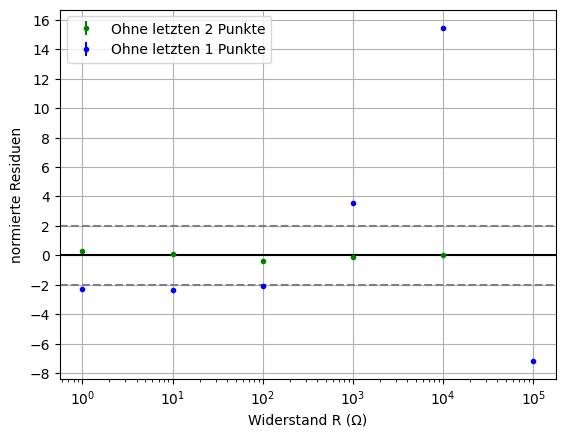

In [5]:
fig, ax = plt.subplots()
ax.axhline(0, color='k')
ax.axhline(2, color='gray', ls='--')
ax.axhline(-2, color='gray', ls='--')
#ax.errorbar(R, norm_res, yerr=np.ones_like(norm_res)*0.1, fmt='r.', label='Alle Punkte')
ax.errorbar(x2, norm_res2, yerr=np.ones_like(norm_res2)*0.1, fmt='g.', label='Ohne letzten 2 Punkte')
ax.errorbar(x3, norm_res3, yerr=np.ones_like(norm_res3)*0.1, fmt='b.', label='Ohne letzten 1 Punkte')
plt.xlabel('Widerstand R (Ω)')
plt.yticks([-8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16])
plt.ylabel('normierte Residuen')
plt.xscale('log')
#plt.ylim(-20, 20)
plt.legend()
plt.grid()
plt.savefig('../plots/johnson_rauschen_widerstand_norm_residuen_red_log.pdf', dpi=300)
plt.show()

# scheise


krise

# Johnson Bandbreite
## Daten einlesen

In [6]:
data2 = np.loadtxt('../data/johnson_bandbreite.txt', skiprows=1)
f_h = data2[:,0] # f_h in Hz
f_h_err = 0.01 * f_h    # 1% Messunsicherheit
f_l = data2[:,1]  # f_l in Hz
f_l_err = 0.01 * f_l    # 1% Messunsicherheit
G = data2[:,2]  # Gain
U_DMM = data2[:,3]  # in Volt
U_DMM_err = np.full_like(U_DMM, 0.01)  # 0.01V Messunsicherheit

R = 1000000  # in Ohm
R_err = 0.01 * R    # 1% Messunsicherheit
print(f"Verwendeter Widerstand: R = {R} Ohm")
for f_hi, f_hi_err, f_li, f_li_err, Gi, U_DMMi, U_DMMi_err in zip(f_h, f_h_err, f_l, f_l_err, G, U_DMM, U_DMM_err):
    print(f"f_h: {f_hi:.2f} ± {f_hi_err:.2f} Hz, f_l: {f_li:.2f} ± {f_li_err:.2f} Hz, G: {Gi:.2f}, U_DMM: {U_DMMi:.3f} ± {U_DMMi_err:.3f} V")

Verwendeter Widerstand: R = 1000000 Ohm
f_h: 100.00 ± 1.00 Hz, f_l: 100000.00 ± 1000.00 Hz, G: 300.00, U_DMM: 0.876 ± 0.010 V
f_h: 100.00 ± 1.00 Hz, f_l: 33000.00 ± 330.00 Hz, G: 300.00, U_DMM: 0.690 ± 0.010 V
f_h: 100.00 ± 1.00 Hz, f_l: 10000.00 ± 100.00 Hz, G: 400.00, U_DMM: 0.742 ± 0.010 V
f_h: 100.00 ± 1.00 Hz, f_l: 3300.00 ± 33.00 Hz, G: 600.00, U_DMM: 0.705 ± 0.010 V
f_h: 300.00 ± 3.00 Hz, f_l: 3300.00 ± 33.00 Hz, G: 600.00, U_DMM: 0.655 ± 0.010 V
f_h: 300.00 ± 3.00 Hz, f_l: 10000.00 ± 100.00 Hz, G: 400.00, U_DMM: 0.719 ± 0.010 V
f_h: 300.00 ± 3.00 Hz, f_l: 33000.00 ± 330.00 Hz, G: 300.00, U_DMM: 0.683 ± 0.010 V
f_h: 300.00 ± 3.00 Hz, f_l: 100000.00 ± 1000.00 Hz, G: 300.00, U_DMM: 0.865 ± 0.010 V
f_h: 1000.00 ± 10.00 Hz, f_l: 100000.00 ± 1000.00 Hz, G: 300.00, U_DMM: 0.879 ± 0.010 V
f_h: 1000.00 ± 10.00 Hz, f_l: 33000.00 ± 330.00 Hz, G: 300.00, U_DMM: 0.692 ± 0.010 V
f_h: 1000.00 ± 10.00 Hz, f_l: 10000.00 ± 100.00 Hz, G: 400.00, U_DMM: 0.734 ± 0.010 V
f_h: 1000.00 ± 10.00 Hz, f_l

## Bandbreite berechnen

In [7]:
delta_f = np.abs(f_h - f_l)
delta_f_err = np.sqrt(f_h_err**2 + f_l_err**2)

V_J2 = U_J_squared(U_DMM, G)
V_J2_err = U_J_squared_err(U_DMM, U_DMM_err, G)
for dfi, dfi_err, U_J2i, U_J2i_err in zip(delta_f, delta_f_err, V_J2, V_J2_err):
    print(f"Δf: {dfi:.2f} ± {dfi_err:.2f} Hz, U_J^2: {U_J2i*10**12:.6f} ± {U_J2i_err*10**12:.6f} V²")

Δf: 99900.00 ± 1000.00 Hz, U_J^2: 270.493827 ± 3.086420 V²
Δf: 32900.00 ± 330.00 Hz, U_J^2: 213.024691 ± 3.086420 V²
Δf: 9900.00 ± 100.00 Hz, U_J^2: 128.732639 ± 1.736111 V²
Δf: 3200.00 ± 33.02 Hz, U_J^2: 54.413580 ± 0.771605 V²
Δf: 3000.00 ± 33.14 Hz, U_J^2: 50.578704 ± 0.771605 V²
Δf: 9700.00 ± 100.04 Hz, U_J^2: 124.809028 ± 1.736111 V²
Δf: 32700.00 ± 330.01 Hz, U_J^2: 210.771605 ± 3.086420 V²
Δf: 99700.00 ± 1000.00 Hz, U_J^2: 267.098765 ± 3.086420 V²
Δf: 99000.00 ± 1000.05 Hz, U_J^2: 271.358025 ± 3.086420 V²
Δf: 32000.00 ± 330.15 Hz, U_J^2: 213.456790 ± 3.086420 V²
Δf: 9000.00 ± 100.50 Hz, U_J^2: 127.482639 ± 1.736111 V²
Δf: 2300.00 ± 34.48 Hz, U_J^2: 54.104938 ± 0.771605 V²


=== Fit ===
Fit-Ergebnisse: m = 2.459e-15 ± 1.843e-17, b = 5.773e-11 ± 4.275e-13
Chi^2: 4903.12, dof: 10, reduced Chi^2: 490.31
2.0873140658646923e-24
2.6093449393852396e-26


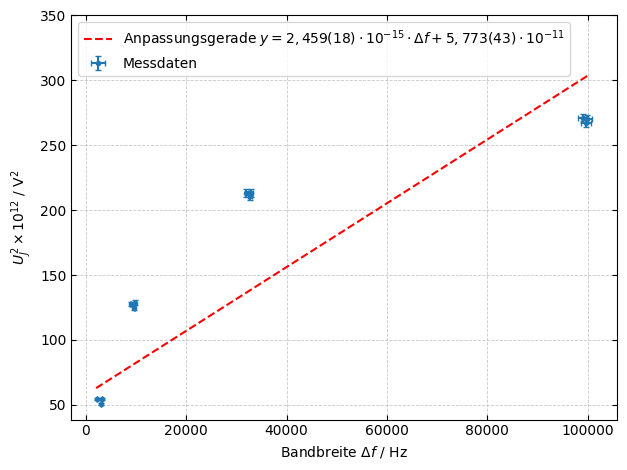

In [10]:
# Fitten der Werte
print("=== Fit ===")
x = delta_f
x_err = delta_f_err
y = V_J2
y_err = V_J2_err
popt, pcov = curve_fit(linear_func, x, y, sigma=y_err, absolute_sigma=True)
m_fit, b_fit = popt
m_fit_err, b_fit_err = np.sqrt(np.diag(pcov))
print(f"Fit-Ergebnisse: m = {m_fit:.3e} ± {m_fit_err:.3e}, b = {b_fit:.3e} ± {b_fit_err:.3e}")

# -- compute chi^2
y_fit = linear_func(x, *popt)
chi2 = np.sum(((y - y_fit) / y_err) ** 2)
dof = len(y) - len(popt)
reduced_chi2 = chi2 / dof
print(f"Chi^2: {chi2:.2f}, dof: {dof}, reduced Chi^2: {reduced_chi2:.2f}")
# Berechne Boltzmann-Konstante aus dem Anstieg
k_B_fit = m_fit / (4* T * R)
k_B_fit_err = np.sqrt(
    (m_fit_err / (4 * T * R))**2 +
    ((m_fit * T_err) / (4*R*T**2))**2 +
    ((m_fit * R_err) / (4* T * R**2))**2
)
print(k_B_fit)
print(k_B_fit_err)

# plot the results
fig, ax = plt.subplots()
ax.errorbar(x, y*10**12, xerr=x_err, yerr=y_err*10**12, fmt='.', label='Messdaten', capsize=2)
ax.set_ylim(top=350)
#ax.set_xlim(left=900)
#ax.set_xscale('log')
#ax.set_yscale('log')
x_fit = np.linspace(min(x)*0.9, max(x)*1, 100)
y_fit = linear_func(x_fit, *popt)
ax.plot(x_fit, y_fit*10**12, 'r--', label=r'Anpassungsgerade $y = 2,459(18)\cdot 10^{-15} \cdot \Delta f + 5,773(43)\cdot 10^{-11}$')
# Labels
ax.set_xlabel(r'Bandbreite $\Delta f$ / Hz')
ax.set_ylabel(r'$U_J^2 \times 10^{12}$ / V$^2$')

# Minor grid & tick marks
ax.grid(which='major', linestyle='--', linewidth=0.6, alpha=0.7)
ax.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
ax.tick_params(which='both', direction='in', top=True, right=True)

# Legend
ax.legend(frameon=True, loc='upper left')

plt.tight_layout()
#plt.grid()
#plt.legend()
plt.savefig('../plots/johnson_rauschen_bandbreite.pdf', dpi=300)   
plt.show()

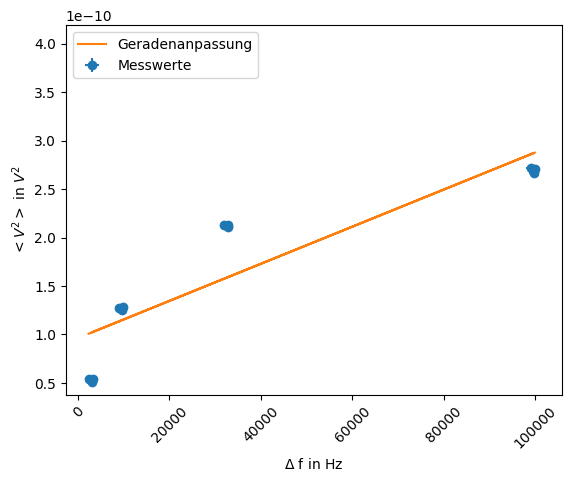

1.0495470190148636e-14
8.079637208054219e-12


In [ ]:
%matplotlib inline
import numpy as np
import datetime
import matplotlib.pyplot as plt

x = delta_f #delta f
y = V_J2 #Johnson-Rauschen
x_err = delta_f_err
y_err = V_J2_err

coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)

#plotten
fig, ax = plt.subplots()
ax.errorbar(x, y, xerr=x_err, yerr=y_err, ls='none', marker='o', label='Messwerte')
plt.plot(x, poly1d_fn(x), label='Geradenanpassung')
#plt.plot(x2, poly1d_fn2(x2), color='red', label='Geradenanpassung ohne die ersten beiden Messwerte')
ax.legend(loc ='upper left')
#ax.set_title('')
bottom, top =plt.ylim()
plt.ylim(bottom, top*1.4)
ax.set_xlabel(r'$\Delta$ f in Hz')
ax.set_ylabel(r'$<V^2>$ in $V^2$')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.tick_params(axis='x', labelrotation=45)
plt.savefig('P425-f1')
plt.show()

slope, intercept = np.polyfit(x2, y2, 1)
print(slope)
print(intercept)

#x = np.array([111.07, 36.65, 11.11, 3.67, 1.11, 0.37]) #delta f
#y = np.array([4.99, 1.51, 0.426, 0.15, 0.0519, 0.0138])*10**(-17) #Schrotrauschen
#x_err = 0.1*x
#y_err = np.array([3.75, 0.938, 0.267, 0.15, 0.0375, 0.00938])*10**(-19)

#coef = np.polyfit(x, y, 1, full=False, cov=True)
#print(coef)